In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential, save_model
from keras.layers import LSTM, Dropout, Dense

import matplotlib.pyplot as plt

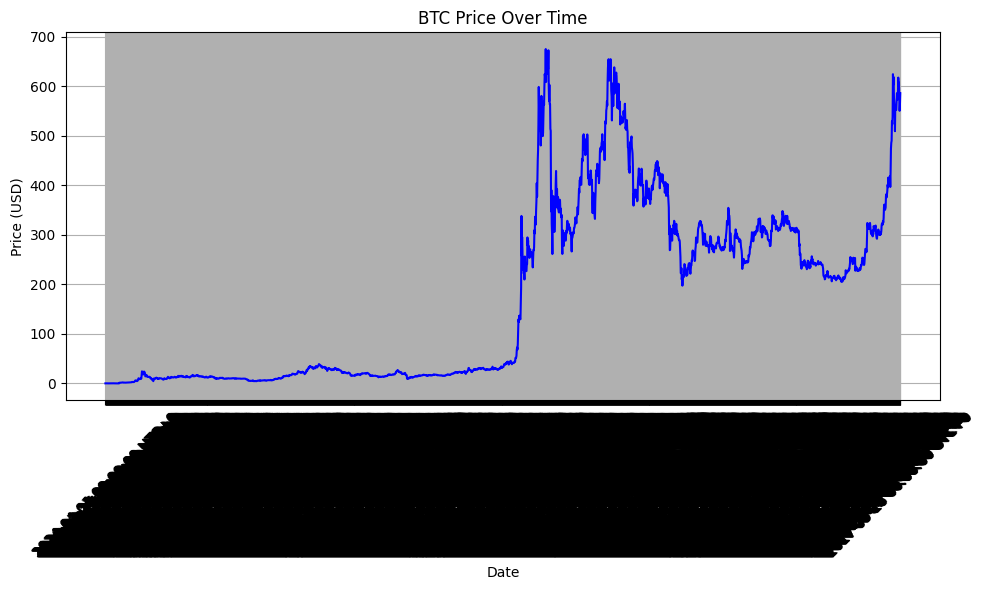

In [22]:
df = pd.read_csv('data/bnc_data.csv').dropna(axis=0)
f_df = df[['Date','Price']]

# Assuming selected_df contains the 'Date' and 'Price' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price'][::-1], color='blue', linestyle='-')
plt.title('BTC Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
f_df = f_df['Price']

sc = MinMaxScaler(feature_range=(0,1))

f_df = sc.fit_transform(np.array(f_df).reshape(-1,1))
print(f_df.shape)

(2391, 1)


In [24]:
training_size=int(len(f_df)*0.60)
test_size=len(f_df)-training_size
train_data,test_data=f_df[0:training_size,:],f_df[training_size:len(f_df),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1434, 1)
test_data:  (957, 1)


In [25]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1418, 15)
y_train:  (1418,)
X_test:  (941, 15)
y_test (941,)


In [27]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1418, 15, 1)
X_test:  (941, 15, 1)


In [28]:
model = Sequential([
    LSTM(10, input_shape=(None, 1), activation='relu'),
    Dense(1)
])

model.compile(loss="mean_squared_error",optimizer="adam")

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2539 - val_loss: 0.0096
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395 - val_loss: 0.0313
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0224
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0162
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0081
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

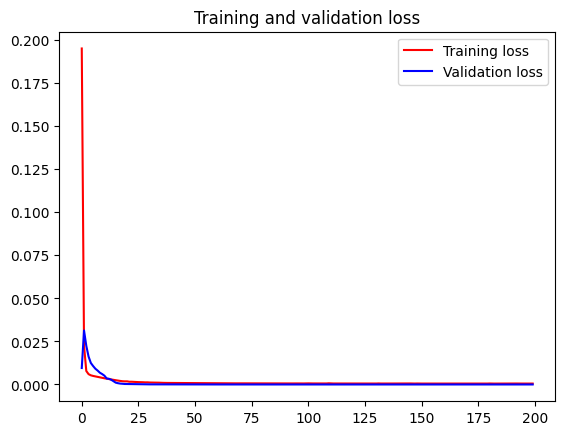

<Figure size 640x480 with 0 Axes>

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [31]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


((1418, 1), (941, 1))

In [32]:
train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)
original_ytrain = sc.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = sc.inverse_transform(y_test.reshape(-1,1)) 

In [33]:
print(train_predict)

print('Now test data')
print(test_predict[:,0])



[[546.5236  ]
 [551.1287  ]
 [512.41614 ]
 ...
 [ 17.090717]
 [ 17.194012]
 [ 17.279915]]
Now test data
[16.254797  15.81663   15.947236  15.808377  15.445817  15.082739
 14.836458  15.181213  15.384604  15.350926  15.513915  15.071847
 14.861558  14.567627  14.31284   14.036468  13.832583  13.564906
 13.101662  13.167907  13.246264  13.609318  13.493961  13.478852
 13.341208  12.9245825 12.994579  12.9700775 13.107443  12.491367
 12.141404  11.594298  11.645859  11.570978  11.812917  11.426959
 13.835445  15.280168  16.016293  16.55796   18.0485    19.353832
 19.90511   19.916922  19.773468  19.790413  19.456238  19.39219
 19.215233  19.165714  18.977184  19.509644  20.418865  21.239605
 21.3484    21.498503  21.5887    21.679966  22.403425  22.620733
 22.780228  23.03056   23.998075  24.201591  24.721455  24.712523
 24.555498  23.957945  22.81907   22.31572   21.438309  20.414515
 19.443634  19.030594  18.773577  18.522373  18.37183   18.46763
 18.249664  18.216764  18.040064  17.873

In [34]:

x_input=f_df[::-1][len(f_df)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [35]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [36]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = sc.inverse_transform(f_df[len(f_df)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = sc.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

next_predicted_days_value[time_step+1:]


[574.1141683791093,
 569.974459728032,
 565.8679865591073,
 561.6510637551839,
 557.2717860233116,
 552.8643828652594,
 548.3093916339192,
 543.6231081770777,
 538.8249668020956,
 534.1101957891234,
 529.4058058347412,
 524.8999435667283,
 520.4017262643437,
 515.8299563452824,
 511.31005148251006,
 506.9169725758456,
 502.59406640631687,
 498.3546110721205,
 494.20319355263354,
 490.14259017747884,
 486.1744506497656,
 482.30010277931365,
 478.5202708260245,
 474.8344317133026,
 471.241418577973,
 467.7398231368937,
 464.3274726103598,
 461.00324037185766,
 457.76539624495564,
 454.6116869766264]

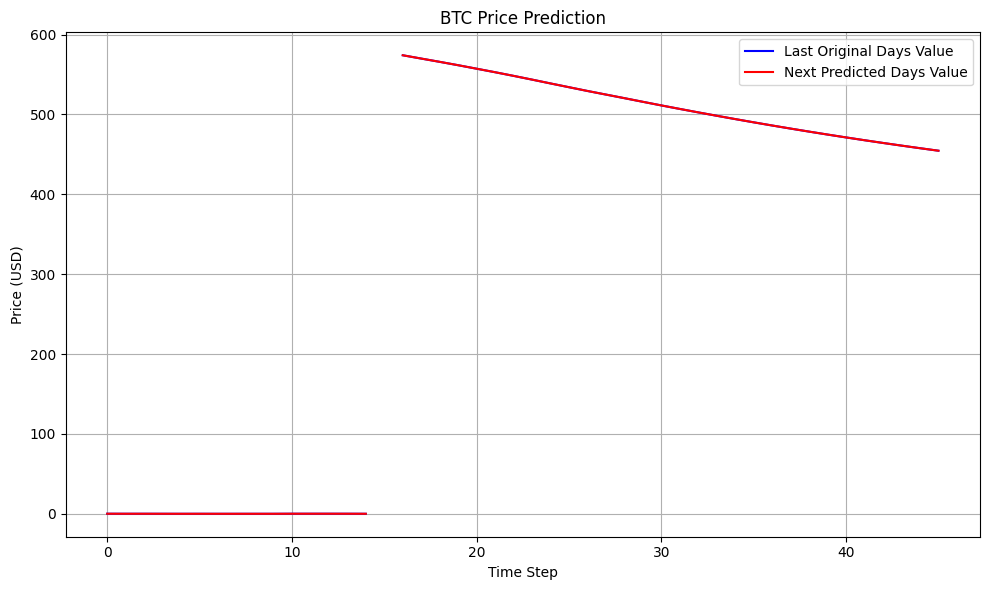

In [37]:


plt.figure(figsize=(10, 6))
plt.plot(new_pred_plot.index, new_pred_plot['last_original_days_value'], color='blue', label='Last Original Days Value')
plt.plot(new_pred_plot.index, new_pred_plot['next_predicted_days_value'], color='red', label='Next Predicted Days Value')
plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
from itertools import cycle

lstmdf=f_df[::-1].tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=sc.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])


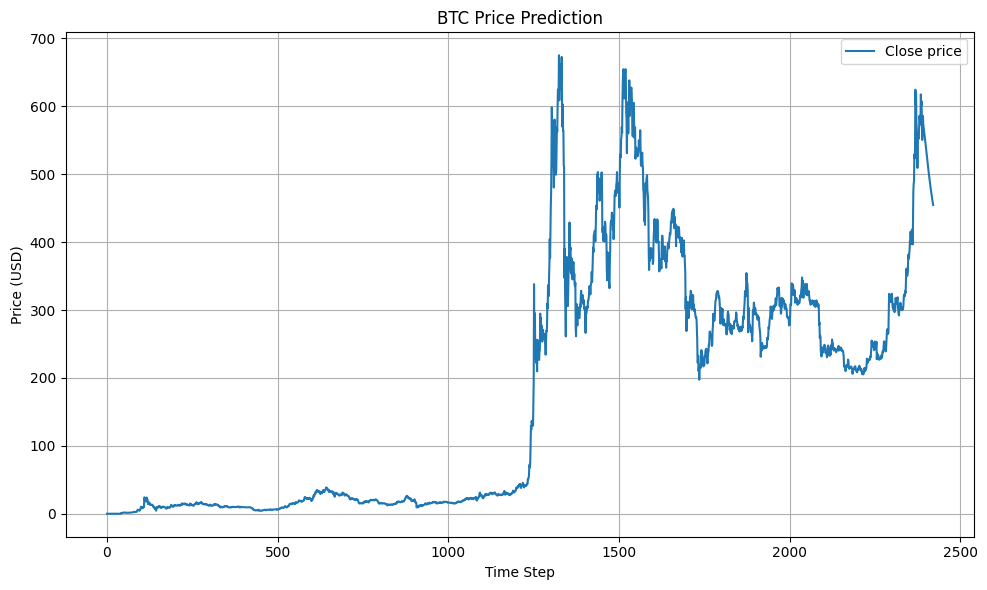

In [39]:

# Plot the data
plt.figure(figsize=(10, 6))
for name, data in zip(names, [lstmdf]):
    plt.plot(data, label=name)

plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


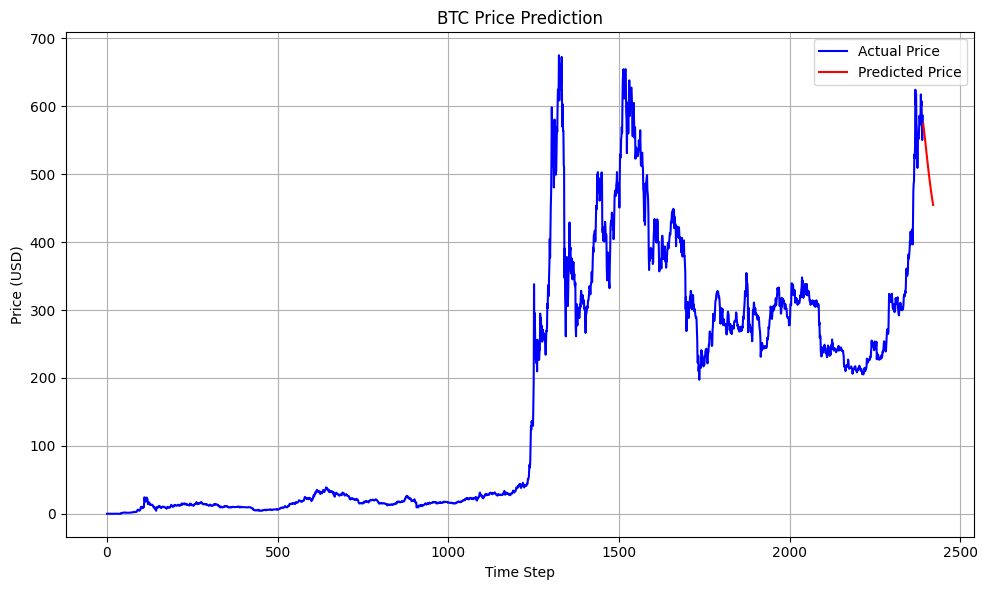

[574.1141683791093,
 569.974459728032,
 565.8679865591073,
 561.6510637551839,
 557.2717860233116,
 552.8643828652594,
 548.3093916339192,
 543.6231081770777,
 538.8249668020956,
 534.1101957891234,
 529.4058058347412,
 524.8999435667283,
 520.4017262643437,
 515.8299563452824,
 511.31005148251006,
 506.9169725758456,
 502.59406640631687,
 498.3546110721205,
 494.20319355263354,
 490.14259017747884,
 486.1744506497656,
 482.30010277931365,
 478.5202708260245,
 474.8344317133026,
 471.241418577973,
 467.7398231368937,
 464.3274726103598,
 461.00324037185766,
 457.76539624495564,
 454.6116869766264]

In [40]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(lstmdf[:len(f_df)], color='blue', label='Actual Price')

# Plot predicted data
plt.plot(range(len(f_df), len(lstmdf)), lstmdf[len(f_df):], color='red', label='Predicted Price')

plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lstmdf[len(f_df):]

here 1 timestep is equal to a 15 day interval of data, hence, 1 timestep = 15 days

In [41]:
save_model(model, 'models/bnc_model.keras')